# Exploring the Data

In [193]:
import pandas as pd
from pandas_datareader import data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [194]:
start_date='2001-01-01'
end_date='2018-01-01'
goog_data=data.DataReader('GOOG','yahoo',start_date,end_date)

In [195]:
def create_classification_trading_condition(df):
    df["Open-Close"]=df.Open-df.Close
    df["High-Low"]=df.High-df.Low
    df=df.dropna(inplace=True)
    X=df[["Open-Close","High-Low"]]
    Y=np.where(df["Close"].shift(-1)>df["Close"],1,-1)#This keeps account of direction of price movement
    return (X,Y)

def create_regression_trading_condition(df):
    df["Open-Close"]=df.Open-df.Close
    df["High-Low"]=df.High-df.Low
    df["Target"]=df["Close"].shift(-1)-df["Close"]
    df.dropna(inplace=True)
    X=df[["Open-Close","High-Low"]]
    Y=df["Target"]#This keeps account of direction as well as magnitude of price movement
#     X.drop(X.index[-1],inplace=True)
#     Y.dropna(inplace=True)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

# Ordinary Least Squares

## Assumptions of OLS
1. target variable is a linear combination of the feature values
2. independence of feature values themselves
3. normally distributed error terms

In [196]:
# Create and populate target variable , for regression. 

X, Y = create_regression_trading_condition(goog_data)

<Figure size 1152x432 with 0 Axes>

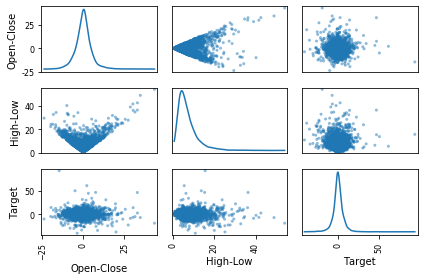

In [197]:
# Scatter Plot for features:- Open-close, High-Low agains the target variable NextDay's Price-Current Price
plt.figure(figsize=(16,6))
pd.plotting.scatter_matrix(goog_data[["Open-Close","High-Low","Target"]],grid=True,diagonal="kde")
plt.tight_layout()

In [198]:
# Split the data into train and test

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [199]:
# Fit the OLS model

from sklearn import linear_model
ols=linear_model.LinearRegression()
ols.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [200]:
# Print the coefficients

print('Coefficients: \n', ols.coef_)

Coefficients: 
 [ 0.02410177 -0.05781461]


In [201]:
# Performance Metrics for training data

from sklearn.metrics import mean_squared_error, r2_score

# The mean_squared_error
mse=mean_squared_error(Y_train,ols.predict(X_train))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_train,ols.predict(X_train))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:27.52
Variance score:0.00


In [202]:
# Performance Metrics for test data

# The mean_squared_error
mse=mean_squared_error(Y_test,ols.predict(X_test))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_test,ols.predict(X_test))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:103.50
Variance score:-0.01


In [203]:
# Predict Prices and calculate strategy returns

goog_data["Predicted_Signal"]=ols.predict(X)#Target Price as predicted by model
goog_data["GOOG_Returns"]=np.log(goog_data["Close"]/goog_data["Close"].shift(1))#Log daily returns of GOOG

In [204]:
def calculate_return(df,split_value,symbol):
    cum_goog_return=((1+df[split_value:][symbol+"_Returns"]).cumprod()-1)*100#Returns for period after X_train i.e. for X_test
    arr=[]
    for i in range(len(df)):
        cond=(df["Predicted_Signal"].shift(1))[i]/[df["Target"].shift(1)[i]]
        if cond<0:
            if df["Target"].shift(1)[i]>0:
                arr.append(-df[symbol+"_Returns"][i])
            else:
                arr.append(df[symbol+"_Returns"][i])
        elif cond>=1:
            if df["Target"].shift(1)[i]>0:
                arr.append(df[symbol+"_Returns"][i])
            else:
                arr.append(-df[symbol+"_Returns"][i])
        else:
             arr.append(np.abs((df["Predicted_Signal"].shift(1))[i]/df["Close"][i-1]))
    df["Strategy_Returns"]=arr
    return cum_goog_return
        
    return cum_goog_return
def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return =((1+df[split_value:]['Strategy_Returns']).cumprod()-1) * 100
    return cum_strategy_return

In [205]:
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol="GOOG")
cum_strategy_return=calculate_strategy_return(goog_data,split_value=len(X_train),symbol="GOOG")

C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [206]:
def plot_chart(cum_symbol_return,cum_strategy_return,symbol):
    plt.figure(figsize=(16,6))
    plt.plot(cum_symbol_return, label=symbol+" Returns")
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std=strategy_returns.std()
    risk_free_rate=0.02651826667614543 #Acc to SBI 6.91% per year
    sharpe=(strategy_returns-risk_free_rate)/strategy_std
    return sharpe.mean()

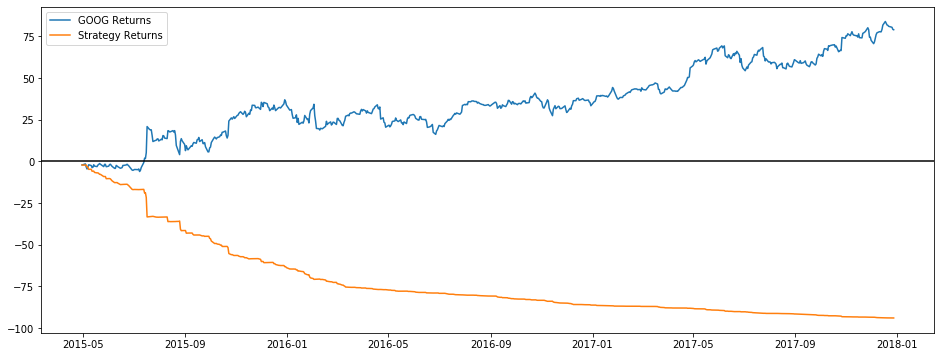

In [207]:
plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')
plt.axhline(y=0,color="k")

In [208]:
print("Sharpe Ratio is: "+str(sharpe_ratio(cum_strategy_return,cum_goog_return)))

Sharpe Ratio is: -3.0519180229347658


# Regularization

In [209]:
from sklearn import linear_model

# Fit the model

lasso=linear_model.Lasso(alpha=0.5)
lasso.fit(X_train,Y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [210]:
# The coefficients

print('Coefficients: \n',lasso.coef_)

Coefficients: 
 [ 0.         -0.01371393]


In [211]:
# Performance Metrics for training data

from sklearn.metrics import mean_squared_error, r2_score

# The mean_squared_error
mse=mean_squared_error(Y_train,lasso.predict(X_train))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_train,lasso.predict(X_train))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:27.54
Variance score:0.00


In [212]:
# Performance Metrics for test data

# The mean_squared_error
mse=mean_squared_error(Y_test,lasso.predict(X_test))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_test,lasso.predict(X_test))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:103.13
Variance score:-0.00


C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


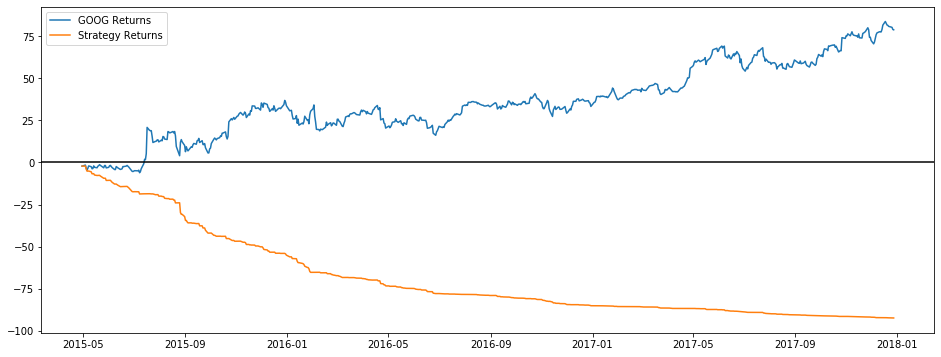

In [213]:
# Predict Prices and calculate strategy returns

goog_data["Predicted_Signal"]=lasso.predict(X)#Target Price as predicted by model
goog_data["GOOG_Returns"]=np.log(goog_data["Close"]/goog_data["Close"].shift(1))#Log daily returns of GOOG
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol="GOOG")
cum_strategy_return=calculate_strategy_return(goog_data,split_value=len(X_train),symbol="GOOG")
plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')
plt.axhline(y=0,color="k")

In [214]:
print("Sharpe Ratio is: "+str(sharpe_ratio(cum_strategy_return,cum_goog_return)))

Sharpe Ratio is: -2.760643800824569


# Ridge Regression

In [215]:
from sklearn import linear_model

# Fit the model
ridge = linear_model.Ridge(alpha=20000)
ridge.fit(X_train, Y_train)

Ridge(alpha=20000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [216]:
# The coefficients

print('Coefficients: \n', ridge.coef_)

Coefficients: 
 [ 0.01425736 -0.03531463]


In [217]:
# Performance Metrics for training data

from sklearn.metrics import mean_squared_error, r2_score

# The mean_squared_error
mse=mean_squared_error(Y_train,ridge.predict(X_train))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_train,ridge.predict(X_train))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:27.52
Variance score:0.00


In [218]:
# Performance Metrics for test data

# The mean_squared_error
mse=mean_squared_error(Y_test,ridge.predict(X_test))
print("Mean squared error:"+"{:.2f}".format(mse))

# Explained Variance Score: 1 is perfect prediction

r2=r2_score(Y_test,ridge.predict(X_test))
print("Variance score:"+"{:.2f}".format(r2))

Mean squared error:103.28
Variance score:-0.00


C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


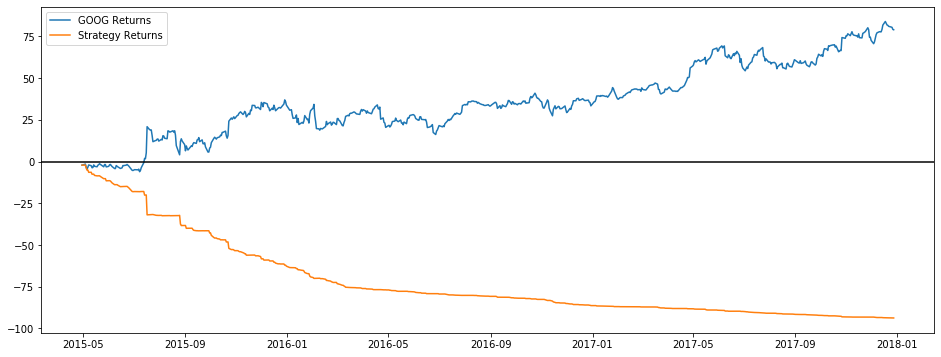

In [219]:
# Predict Prices and calculate strategy returns

goog_data["Predicted_Signal"]=ridge.predict(X)#Target Price as predicted by model
goog_data["GOOG_Returns"]=np.log(goog_data["Close"]/goog_data["Close"].shift(1))#Log daily returns of GOOG
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol="GOOG")
cum_strategy_return=calculate_strategy_return(goog_data,split_value=len(X_train),symbol="GOOG")
plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')
plt.axhline(y=0,color="k")

In [220]:
print("Sharpe Ratio is: "+str(sharpe_ratio(cum_strategy_return,cum_goog_return)))

Sharpe Ratio is: -3.0083481975583846
